# Podsumowanie projektu
### Autorzy:  Jakub Janowski, Mateusz Szpyrka

### Temat:  badanie korelacji pomiędzy przebiegiem epidemii COVID-19 a aktywnością użytkowników Twittera

### Założenia dotyczące działania aplikacji:

- aplikacja ma służyć badaniu zależności pomiędzy aktywnością użytkowników twittera a przebiegiem epidemii koronawirusa wewnątrz poszczególnych państw
- aplikacja powinna umożliwiać zbadanie korelacji wybranej obserwowanej zmiennej pomiędzy państwami na całym świecie
- analiza powinna dodatkowo być przeprowadzona z uwzględnieniem wyłącznie kont popularnych (tzn. o odpowiednio wysokiej liczbie followersów)

In [40]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from summary_utils import CountryLookup

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

In [41]:
def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
        
    return data

# 1. Zbieranie danych

### 1a. Dane z Twittera

Za aktywność na Twitterze uznawaliśmy liczbę tweetów dodawanych z hashtagami #coronavirus lub #covid-19. Tweety pobieraliśmy przy pomocy Twitter streaming API (prawie) nieprzerwanie w przedziale czasowym 7.03 - 12.04. Z pobranych tweetów wyciągaliśmy pola mogące przydać się do późniejszej analizy, a uzyskane rekordy zapisywaliśmy w plikach po 50 tys. rekordów.

In [28]:
# zapisywane metadane tweeta:

TWEET_METADATA = [
    'created_at',
    'text',
    'id',
    'coordinates',
    'place',
    'lang'
]

TWEET_NESTED_METADATA = {
    'user': ['id', 'location', 'followers_count'],
    'entities': ['hashtags']
}


# przykładowy rekord

sample_chunk = load_json('./summary-data/COVIDtweets-0000.json')    
print('sample record:')
print(sample_chunk['records'][0])

sample record:
{'created_at': 'Sat Mar 07 10:59:03 +0000 2020', 'text': 'RT @serdarkaragoz: Just “eyvallah”\n#coronavirus https://t.co/C2tMUNJV4e', 'id': 1236244970253824000, 'coordinates': None, 'place': None, 'lang': 'tr', 'user': {'id': 255122356, 'location': 'terre', 'followers_count': 4528}, 'entities': {'hashtags': [{'text': 'coronavirus', 'indices': [35, 47]}]}}


### 1b. Statystyki COVID-19

Dane dotyczące dziennych przypadków zachorowań, wyzdrowień i zgonów w poszczególnych regionach geograficznych pobieraliśmy z repozytorium: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [8]:
repo_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
files = [
    'time_series_covid19_confirmed_global.csv',
    'time_series_covid19_deaths_global.csv',
    'time_series_covid19_recovered_global.csv'
]

confirmed_data = pd.read_csv(repo_url + files[0])
confirmed_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,933,946,948,949,964,969,981,989,998,1004
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,761,761,761,761,762,762,762,762,762,763
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,48,48,50,52,52,58,60,61,69,70


# 2. Wstępne przetwarzanie danych z Twittera

W celu przygotowania danych do wygodnej analizy konieczne było ich wstępne przetworzenie:
    - podział tweetów ze względu na państwo pochodzenia
    - zliczenie dziennej liczby tweetów pochodzących z każdego państwa
    - wygenerowanie plików z dziennymi statystykami dla poszczególnych państw

### 2a. wyznaczenie państwa pochodzenia tweeta

Ze względu na brak danych dotyczących lokalizacji dodania tweeta w zdecydowanej większości przypadków (ponad 99%) postanowiliśmy brać pod uwagę pole lokalizacji konta, z którego pochodzi tweet.


Nazwy państw w języku angielskim i w językach lokalnych: https://www.omniglot.com/countries/

![alt text](imgs/countries-names.png "Title")

In [51]:
# tabela potencjalnych nazw panstw

global_names_df = pd.read_csv('./summary-data/global_names.csv',
                              keep_default_na=False, na_values=[''], index_col=0)
global_names_df.head()

,continent,english_name,native_names,alpha_2
0,europe,albania,"['shqipëria', 'republika e shqipërisë', 'repub...",AL
1,europe,andorra,"['andorra', ""principat d'andorra"", 'principali...",AD
2,europe,austria,"['österreich', 'republik österreich', 'republi...",AT
3,europe,azerbaijan,"['azərbaycan', 'азәрбајҹан', 'آذربايجان', 'azə...",AZ
4,europe,belarus,"['biełaruśбеларусь', 'respublika biełaruś', 'р...",BY


In [18]:
# mapowanie nazwy panstwa na kodowanie alpha2

country_lookup = CountryLookup('./summary-data/global_names.csv')
country_lookup.translation_dict

{'albania': 'AL',
 'shqipëria': 'AL',
 'republika e shqipërisë': 'AL',
 'republic of albania': 'AL',
 'andorra': 'AD',
 "principat d'andorra": 'AD',
 'principality of andorra': 'AD',
 'austria': 'AT',
 'österreich': 'AT',
 'republik österreich': 'AT',
 'republic of austria': 'AT',
 'azerbaijan': 'AZ',
 'azərbaycan': 'AZ',
 'азәрбајҹан': 'AZ',
 'آذربايجان': 'AZ',
 'azərbaycan respublikası': 'AZ',
 'азәрбајҹан республикаси': 'AZ',
 'azerbaijani republic': 'AZ',
 'republic of azerbaijan': 'AZ',
 'belarus': 'BY',
 'biełaruśбеларусь': 'BY',
 'respublika biełaruś': 'BY',
 'рэспублика беларусь': 'BY',
 'republic of belarus': 'BY',
 'belgium': 'BE',
 'belgië': 'BE',
 'belgique': 'BE',
 'belgien': 'BE',
 'koninkrijk belgië': 'BE',
 'royaume de belgique': 'BE',
 'königreich belgien': 'BE',
 'kingdom of belgium': 'BE',
 'bosnia and herzegovina': 'BA',
 'bosna i hercegovina': 'BA',
 'босна и херцеговина': 'BA',
 'republic of bosnia and herzegovina': 'BA',
 'bulgaria': 'BG',
 'българия': 'BG',
 'ре

In [31]:
sample_locations = ['Chatburn, England. ', ' ✈', 'Namibia, Windhoek', 'England',
       'Jacksonville, FL', 'Destroying autotune rap music',
       'Philadelphia, PA', 'These are personal comments.',
       'm ( a r t ) a', 'Straight outta Comte ', 'Ile-de-France, France',
       'Pie Barm', 'Baltimore, Maryland', 'SW Michigan',
       'Ikorudu, Nigeria']

# przykladowe odczyty

for location in sample_locations:
    alpha2 = country_lookup[location]
    
    if alpha2 is None:
        alpha2 = '-'
        
    print(location.ljust(40, ' ') + str(alpha2))

Chatburn, England.                      GB
 ✈                                      -
Namibia, Windhoek                       NA
England                                 GB
Jacksonville, FL                        -
Destroying autotune rap music           -
Philadelphia, PA                        -
These are personal comments.            -
m ( a r t ) a                           -
Straight outta Comte                    -
Ile-de-France, France                   FR
Pie Barm                                -
Baltimore, Maryland                     -
SW Michigan                             -
Ikorudu, Nigeria                        NG


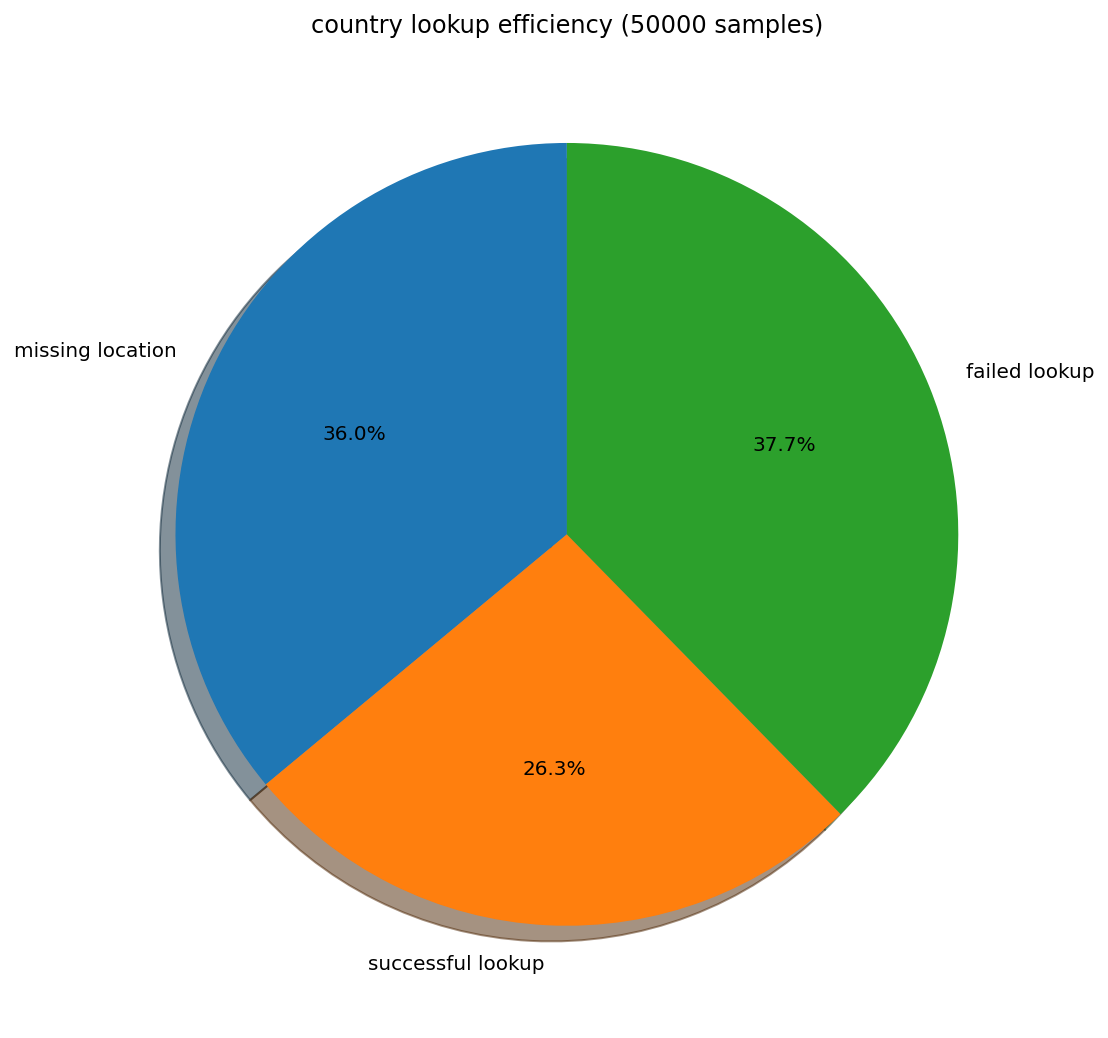

In [44]:
# szacowana skutecznosc algorytmu

no_location_count = 0
failed_lookup_count = 0
successful_lookup_count = 0

for record in sample_chunk['records']:
    tweets_count += 1
    
    location = record['user']['location']
    if location is None:
        no_location_count += 1
        
    else:
        alpha2 = country_lookup[location]
        
        if alpha2 is None:
            failed_lookup_count += 1
            
        else:
            successful_lookup_count += 1
            
labels = ['missing location', 'successful lookup', 'failed lookup']
sizes = [no_location_count, successful_lookup_count, failed_lookup_count]
total = no_location_count + successful_lookup_count + failed_lookup_count

plt.title(f'country lookup efficiency ({total} samples)')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

### 2b. generowanie dziennych podsumowań

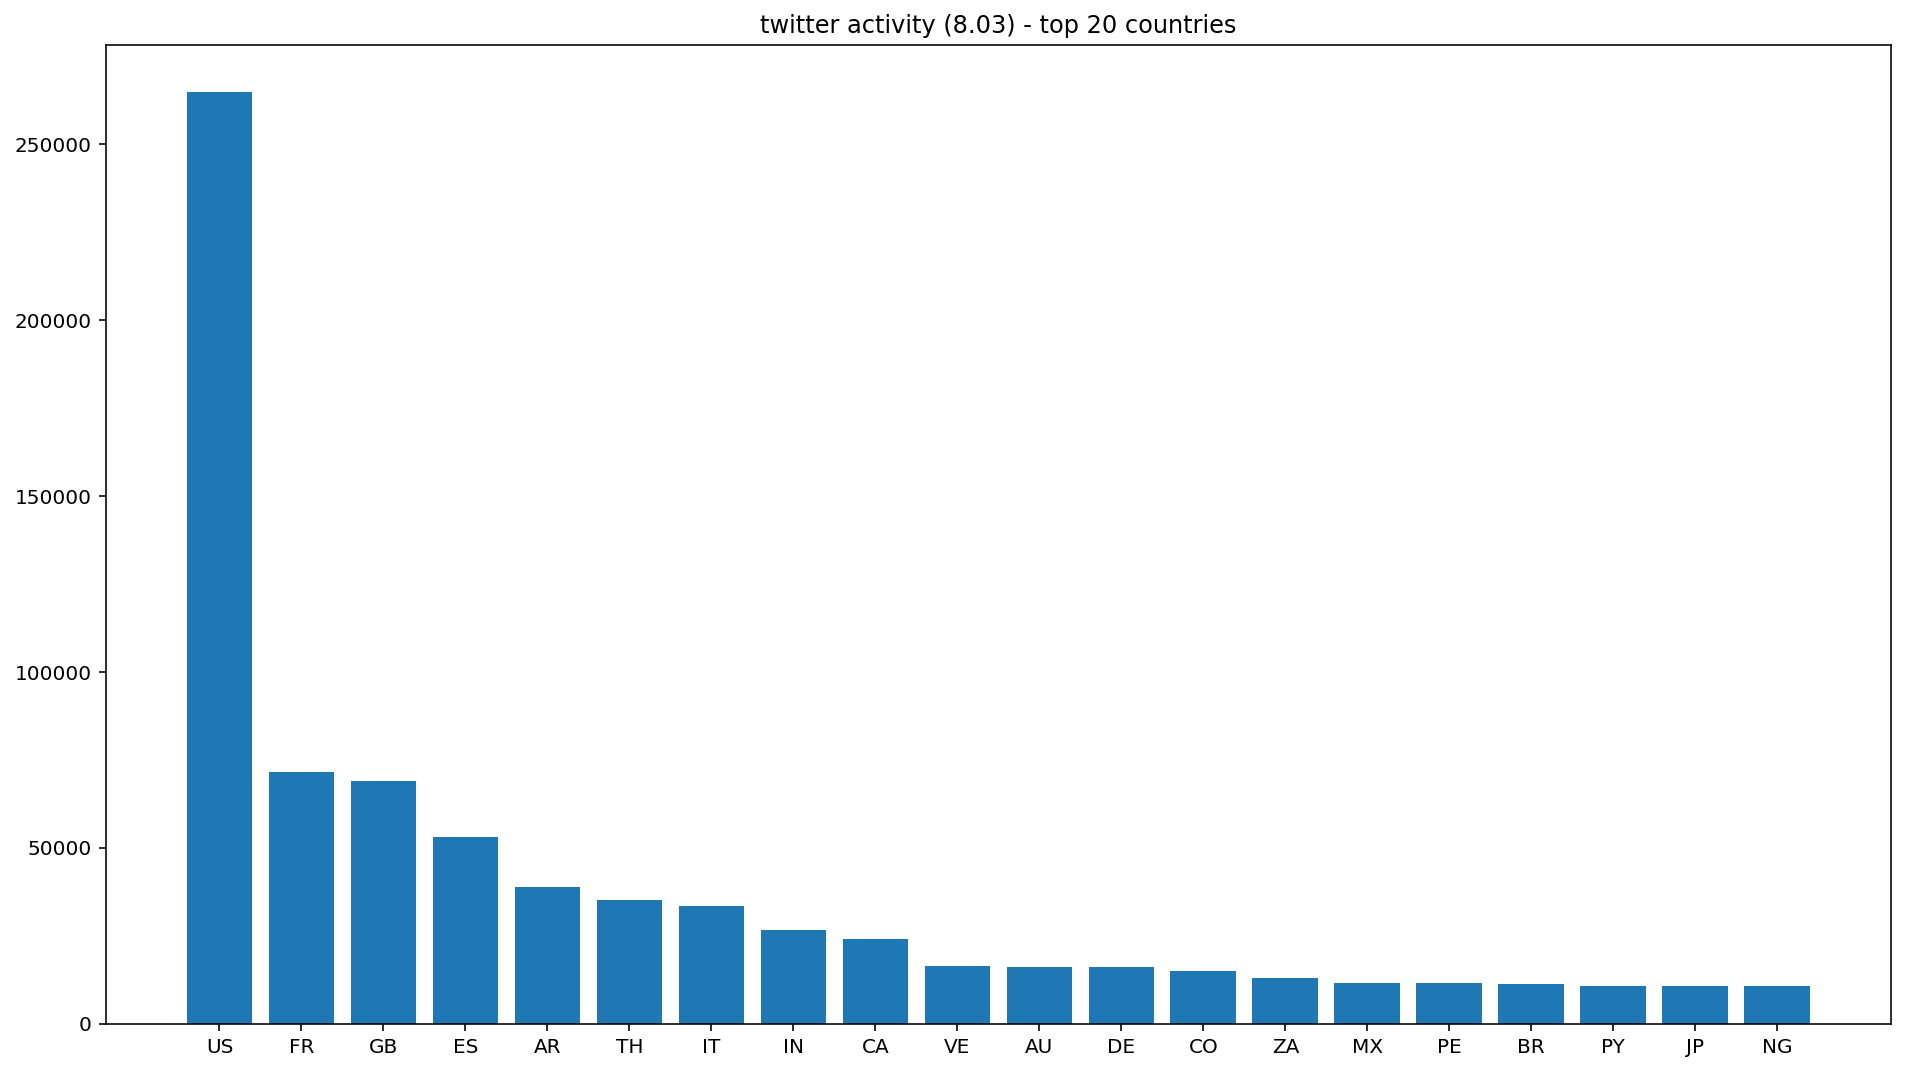

In [50]:
summarized_sample = load_json('./summary-data/2020-03-08-summarized.json')
sorted_items = sorted(summarized_sample.items(), key=lambda i: -i[1])

bars_count = 20
heights = [i[1] for i in sorted_items[:bars_count]]
labels = [i[0] for i in sorted_items[:bars_count]]

plt.title('twitter activity (8.03) - top 20 countries')
plt.bar(labels, heights)
plt.show()

# 3. Konstrukcja bazowych szeregów czasowych

Na podstawie tak przetworzonych danych konstruowaliśmy pięć bazowych szeregów czasowych dla każdego państwa. Poniżej prezentujemy poszczególne szeregi utworzone dla Polski.

### 3a. Dzienna liczba zanotowanych przypadków zachorowań na COVID-19
![title](imgs/series-who-conf-raw.png)

### 3b. Dzienna liczba zaobserwowanych wyzdrowień
![title](imgs/series-who-rec-raw.png)

### 3c. Dzienna liczba zgonów z powodu COVID-19
![title](imgs/series-who-deaths-raw.png)

### 3d. Dzienna liczba tweetów dodanych z hashtagiem "coronavirus" lub "covid-19"
![title](imgs/series-twitter-raw.png)

### 3e. Dzienna liczba tweetów dodanych z hashtagiem "coronavirus" lub "covid-19" przy zastrzeżeniu, że uwzględniane są tylko konta o liczbie followersów >= 1% dziennego maksimum
![title](imgs/series-twitter-followers.png)

# 4. Wygladzanie szeregow czasowych

Wejściowe szeregi czasowe są transformowane przy użyciu średniej kroczącej w celu zredukowania wpływu czynnika ludzkiego na rejestr przebiegu epidemii. Chcieliśmy w ten sposób zminimalizować prawdopodobieństwo sytuacji, w których np. Liczbie zanotowanych przypadków zakażenia koronawirusem następuje nagły skok chorych z dnia na dzień wyłącznie przez to, że w danym dniu zostało przeprowadzone więcej testów (bądź testy w poprzednich dniach nie były wcale przeprowadzane).

Poniżej dane surowe oraz dane wygładzone średnią kroczącą o szerokości okna równej 5 próbek (stąd zakres obejmowanych dat jest mniejszy na drugim wykresie):

![title](imgs/4.png)

# 5. Wizualizacja na mapie swiata

Szereg czasowy zachorowan COVID-19 oraz korelacja z innymi panstwami swiata dla Polski

![title](imgs/fig1a.png)

Szereg czasowy zgonow z powodu COVID-19 oraz korelacja z innymi panstwami dla Polski

![title](imgs/fig1b.png)

Szereg czasowy wyzdrowien z COVID-19 oraz korelacja z innymi panstwami dla Polski

![title](imgs/fig1c.png)

Szereg czasowy aktywnosci uzytkownikow twittera oraz korelacja z innymi panstwami dla Polski

![title](imgs/fig1d.png)

Szeregi czasowe z i bez uwzglednienia progu followersach oraz ich korelacja z innymi panstwami dla Polski

![title](imgs/fig2.png)

Wizualizacja korelacji pomiedzy aktywnoscia twittera i przebiegiem epidemii COVID-19 z i bez uwzglednieniem progu followersow

![title](imgs/fig3.png)